# Parte 1 - Teste de Decaimento

* Cálculo do Amortecimento a partir de um sinal de teste de decaimento

In [55]:
# Bibliotecas
import numpy as np
from scipy.optimize import curve_fit, fsolve
from scipy.signal import find_peaks
import plotly.graph_objects as go

In [56]:
# Função para plotar os decaimentos
def plota_decaimento(t,ydata,picos,vales,Y0=None,zeta=None,wn=None):

    #Definição de marcadores
    marker01 = dict(color='red', symbol='triangle-up', size=9)
    marker02 = dict(color='green', symbol='triangle-down', size=9)
    line1 = dict(color='orange', width=2, dash='dash')
    line2 = dict(color='magenta', width=2, dash='dash')

    # Cria a figura e adiciona as curvas
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=ydata, name='y(t)'))
    fig.add_trace(go.Scatter(x=t[picos], y=ydata[picos], name='Picos', mode='markers', marker=marker01))
    fig.add_trace(go.Scatter(x=t[vales], y=ydata[vales], name='Vales', mode='markers', marker=marker02))

    if Y0 != None:
        # Envoltória
        x_env = Y0*np.exp(-zeta*wn*t)
        fig.add_trace(go.Scatter(x=t, y=x_env, name='envoltória superior', line=line1))
        # fig.add_trace(go.Scatter(x=t, y=-x_env, name='envoltoria inferior', line=line2))
    # Define o título do gráfico e dos eixos
    fig.update_layout(title='Simulação Decaimento', xaxis_title='tempo (s)', yaxis_title='y(t)')
    fig.show()

## Movimento harmônico amortecido

$y(t) = Y_0 \cdot e^{-\zeta \omega_n t} \cdot \cos{(\omega_d t)}$

## Envoltória

$Y_{env} = Y_0 \cdot e^{-\zeta \omega_n t}$

Obs: utilizaremos a função ``` np.random.uniform``` para emular um ruído no sinal

In [57]:
# Decaimento Dummy
Y0 = 10
wn = 2*np.pi/3
zeta = 0.1
tmax = 20
Npts = 500
t = np.linspace(0,tmax,Npts)

wd = wn*np.sqrt(1-zeta**2)
ydata =  Y0*np.sin(wd*t)*np.exp(-zeta*wn*t) + np.random.uniform(-.2,.2,size=Npts)

ydata = ydata - np.mean(ydata)

n = Npts/tmax


# picos, _ = find_peaks(ydata)
# vales, _ = find_peaks(-ydata)
picos, _ = find_peaks(ydata, distance = 2 * n)
vales, _ = find_peaks(-ydata, distance = 2 * n)

picos = picos[0:-1]
vales = vales[0:-1]

plota_decaimento(t,ydata,picos,vales)

## Relação entre frequência natural e frequência natural amortecida

$\omega_d = \omega_n \sqrt{1-\zeta^2}$

$\omega_n = \dfrac{\omega_d}{\sqrt{1-\zeta^2}}$

In [58]:
# Frequencia amortecida
wd_measure = np.mean(2*np.pi/np.diff(t[picos]))
print(f'Frequencia natural = {wn:.3f} rad/s')
print(f'Frequencia natural amortecida = {wd:.3f} rad/s')
print(f'Frequencia natural medida = {wd_measure:.3f} rad/s')

Frequencia natural = 2.094 rad/s
Frequencia natural amortecida = 2.084 rad/s
Frequencia natural medida = 2.072 rad/s


## Função a ser ajustada nos pontos de pico do sinal

Problema: Achar $a$ e $b$ de forma a minimizar a distância da curva ao pontos.

Ferramenta: ```curve_fit```

$f(t) = a \cdot e^{-b \cdot t}$

tal que:

$a = Y_0$

$b = \zeta \cdot \omega_n$

$b = \dfrac{\zeta}{\sqrt{1-\zeta^2}}\omega_d$

Equação a ser resolvida utilizando o ```fsolve```:

$\dfrac{\zeta}{\sqrt{1-\zeta^2}}\omega_d - b = 0$

In [59]:
# Definir a função exponencial
def func(t, a, b):
    return a * np.exp(-b * t)

# Ajustar a curva exponencial usando curve_fit()
popt, pcov = curve_fit(func, t[picos], ydata[picos])

# Imprimir os parâmetros ajustados
print(f'Parâmetros ajustados: a = {popt[0]}, b = {popt[1]}')


# Cálculo dos parâmetros para o sistema
Y0_fit = popt[0]


# Cálculo do amortecimento a partir da frequencia amortecida
def f(x):
    return wd_measure*x/np.sqrt(1-x**2)-popt[1]

x0 = np.array([0.5])
x = fsolve(f, x0)

zeta_fit = x[0]
print(f'Zeta_fit = {zeta_fit:.3f}')

# Observação: Durante a otimização pode aparecer um 'warning' de overflow na função np.exp()
# provavelmente devido a número que excederam a precisão numérica do numpy
# Geralmente o numpy lida bem com aproximações de números grandes

Parâmetros ajustados: a = 9.989225216009093, b = 0.21711668029934672
Zeta_fit = 0.104


C:\Users\dprat\AppData\Local\Temp\ipykernel_4032\2426679144.py:3: RuntimeWarning:

overflow encountered in exp



In [60]:
plota_decaimento(t, ydata, picos, vales, Y0=Y0_fit, zeta=zeta_fit, wn=wn)

# Parte 2 - Medição de experimento de pêndulo simples

* Gravação de um vídeo do experimento
* Medição do movimento através de processamento de imagens utilizando o programa [Kinovea](https://www.kinovea.org/).
* Exemplo de série temporal da posição horizontal medida no `m1_pos_horizontal.csv` incluso no repositório.

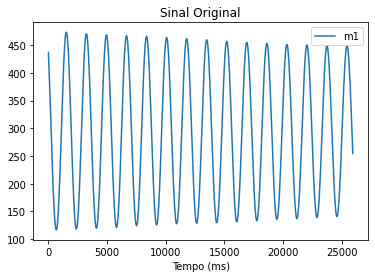

In [61]:
import pandas as pd

df = pd.read_csv('m1_pos_horizontal.csv', sep=';') # o arquivo csv está no repositório

df.plot(x='Tempo (ms)', y='m1', title='Sinal Original'); #visualização rápida do arquivo original

## Processamento do Sinal

In [62]:
t_ = df['Tempo (ms)'].to_numpy()/1000 #converter para segundos
ph = df['m1'].to_numpy()

ph = ph - np.mean(ph)

picos, _ = find_peaks(ph)
vales, _ = find_peaks(-ph)

picos = picos[0:-1]
vales = vales[0:-1]

plota_decaimento(t_,ph,picos,vales)

## Cálculo da frequência e do amortecimento

In [63]:
# acha a frequencia dos picos
wd_ = np.mean(2*np.pi/np.diff(t_[picos]))
print(f'Frequencia angular obtida {wd:.3f} rad/s')

# função da curva exponencial
def func2(t, a, b):
    return a*np.exp(-b*t)

# Ajustar a curva exponencial usando curve_fit()
popt, pcov = curve_fit(func2, t_[picos], ph[picos], p0=[180, .1]) #para funcionar, deve-se fornecer um chute inicial p0 (primeiro pico e um valor baixo de zeta*wn)

# Resultados da otimização
a = popt[0]
b = popt[1]

# Imprimir os parâmetros ajustados
print(f'Parâmetros Ajustados: a = {a:.4f}; b = {b:.4f}')

# Cálculo dos parâmetros para o sistema
Y0_fit = a

# Cálculo do amortecimento a partir da frequencia amortecida
def f(x):
    return wd_*x/np.sqrt(1-x**2)-b

x0 = np.array([0.1]) #chute inicial 10%
x = fsolve(f, x0)

zeta_fit = x[0]

print(f'Amoprtecimento calculado = {zeta_fit*100:.2f}%')


plota_decaimento(t_, ph, picos, vales, Y0=Y0_fit, zeta=zeta_fit, wn=wd_)

Frequencia angular obtida 2.084 rad/s
Parâmetros Ajustados: a = 181.9347; b = 0.0067
Amoprtecimento calculado = 0.18%


## Cálculo do período de oscilação

O período de oscilação de um pêndulo simples é:

$T_0  = 2 \pi \sqrt{\frac{L}{g}}$

No exemplo fornecido o comprimento do cabo era L = 72 cm

In [64]:
L = 0.72 #m
g = 9.81 #m/s²
wn_ = wd_ / np.sqrt(1 - zeta_fit**2)
T0_ = 2*np.pi / wn_
T0_teorico = 2*np.pi*np.sqrt(L/g)

print(f'Período Calculado = {T0_:.2f}s')
print(f'Período Teórico   = {T0_teorico:.2f}s')

Período Calculado = 1.71s
Período Teórico   = 1.70s
